In [1]:
from warnings import filterwarnings
filterwarnings("ignore")


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler
from scipy.stats import linregress,stats
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from prophet import Prophet
from sklearn.metrics import r2_score,mean_absolute_error
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [2]:
df=pd.read_csv('/kaggle/input/stroke-prediction-dataset/healthcare-dataset-stroke-data.csv')
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
df2=df.copy()
df2.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
3,60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
4,1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1


In [3]:
df2.drop('id', axis=1, inplace=True)

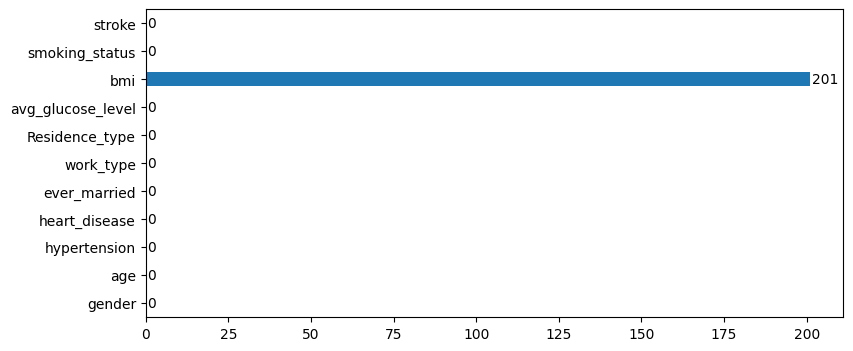

In [4]:
# to find the null values
ax = df2.isnull().sum().plot(kind='barh',figsize=(9,4))

for i, v in enumerate(df2.isnull().sum()):
    ax.text(v + 0.5, i, str(v), va='center', fontsize=10, color='black')

In [5]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [6]:
df2['age'] = df2['age'].astype(int)

In [7]:
df2.shape

(5110, 11)

In [8]:
# cases with values as as zero. 
(df2['age']==0).sum()

43

In [9]:
# lets make a fuction to ensure we endure cases which shouldnt be negative 

def clean_df2(data):
    
    init = data.shape[0]

    data = data[data['age'] > 0]
    data = data[data['hypertension'] >= 0]
    data = data[data['heart_disease'] >= 0]
    data = data[data['avg_glucose_level'] >= 0]
    #data = data[data['bmi'] >= 0] As BMI has null values
    
    diff = data.shape[0]
    
    print('---------------\nTotal columns removed\n---------------\n',(init - diff))
    
    data = data.drop_duplicates()
    data.reset_index(drop=True, inplace=True)
    
    dupli = data.shape[0]
    
    print('---------------\nTotal duplicates removed\n---------------\n',diff-dupli)
    
    data = data[data['gender'] != 'Other']
    
    return data

In [10]:
df2 = clean_df2(df2)

---------------
Total columns removed
---------------
 43
---------------
Total duplicates removed
---------------
 0


In [11]:
def imputing(data):
    knn_imputer = KNNImputer(n_neighbors=5)
    
    for column in data.columns:
        if data[column].isnull().any():
            # Create a DataFrame with only the column you want to impute
            column_to_impute = data[[column]]
            
            # Use the KNNImputer to fill missing values
            imputed_values = knn_imputer.fit_transform(column_to_impute)
            
            # Replace the original column in data with the imputed values
            data[column] = imputed_values

    return data

# Call the imputing function on df2
df2 = imputing(df2)


In [12]:
df2=imputing(df2)

In [13]:
df2.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61,0,0,Yes,Self-employed,Rural,202.21,28.987074,never smoked,1
2,Male,80,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


In [14]:
df2.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5066.000000,5066.000000,5066.000000,5066.000000,5066.000000,5066.000000
mean,43.585472,0.098302,0.054481,106.234272,28.987074,0.049151
std,22.376141,0.297752,0.226986,45.396013,7.661429,0.216205
min,1.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,26.000000,0.000000,0.000000,77.282500,23.900000,0.000000
50%,45.000000,0.000000,0.000000,91.890000,28.400000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,32.800000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


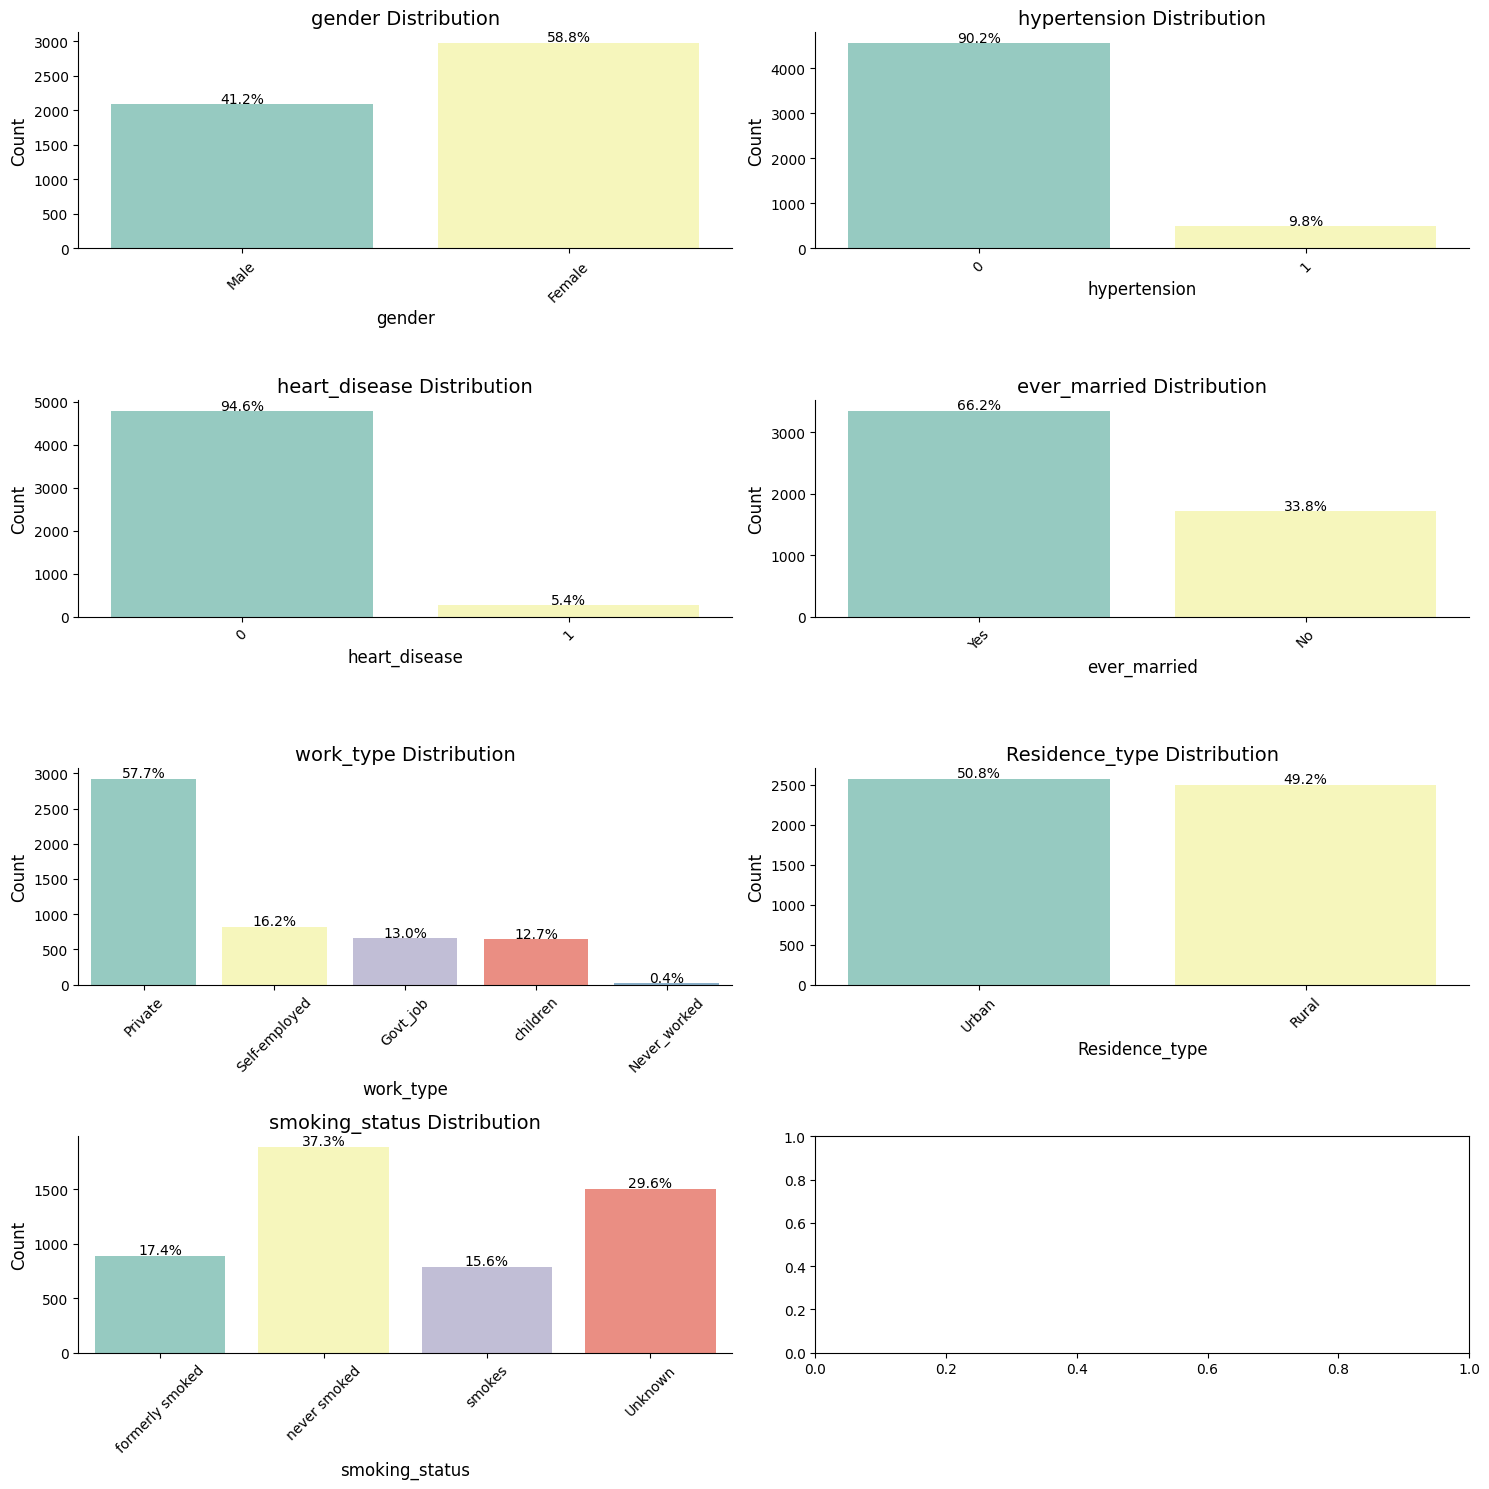

In [15]:
# List of categorical features
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Let's create a separate chart for each feature
fig, axes = plt.subplots(4, 2, figsize=(15, 15)) # Let's create a figure with a subplot in a 4x2 grid layout

for i, ax in zip(columns, axes.flatten()): # A flattened array is obtained with axes.flatten()
    total_count = len(df2[i])
    sns.countplot(data=df2, x=i, ax=ax, palette='Set3') # Let's create a column chart using Seaborn countplot
    ax.set_xlabel(i, fontsize=12) # Let's label the x-axis with the property name
    ax.set_ylabel('Count', fontsize=12) # Let's label the Y-axis with "Count"
    ax.set_title(f'{i} Distribution', fontsize=14) # Set a title for each subplot
    ax.tick_params(axis='x', rotation=45) # Rotate x-axis labels for better readability
    
        # Adding percentage text on top of each bar
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total_count)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 20
        ax.annotate(percentage, (x, y), ha='center')
        
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
        
plt.tight_layout()
plt.show()

1. **Gender Imbalance**: The data reveals a notable gender imbalance, with a higher representation of women compared to men. This gender skew may have implications for understanding the prevalence and impact of various health factors in the population.

2. **Prevalence of Hypertension and Heart Disease**: It's noteworthy that a substantial portion of the population does not have hypertension or heart disease. This indicates a positive health trend in the dataset, but further analysis is needed to assess the potential risk factors and health outcomes.

3. **Marital Status**: The majority of individuals in the dataset report being married. However, the significant percentage of individuals who have never married (around 30%) raises questions about the demographic characteristics of this group and their potential health-related behaviors.

4. **Work Profiles**: Many individuals in the dataset work in private sector jobs. Understanding the distribution of work profiles can provide insights into socioeconomic factors and access to healthcare services.

5. **Residence Type**: The even distribution between urban and rural residences suggests a balanced representation of different living environments. This can be valuable for assessing healthcare access and health disparities between urban and rural areas.

6. **Smoking Habits**: The dataset reveals interesting patterns related to smoking habits. While a substantial proportion of individuals have never smoked (around 37%), the presence of a significant percentage with unknown smoking status (around 30%) underscores the importance of data completeness and the potential impact on health analysis and interventions.

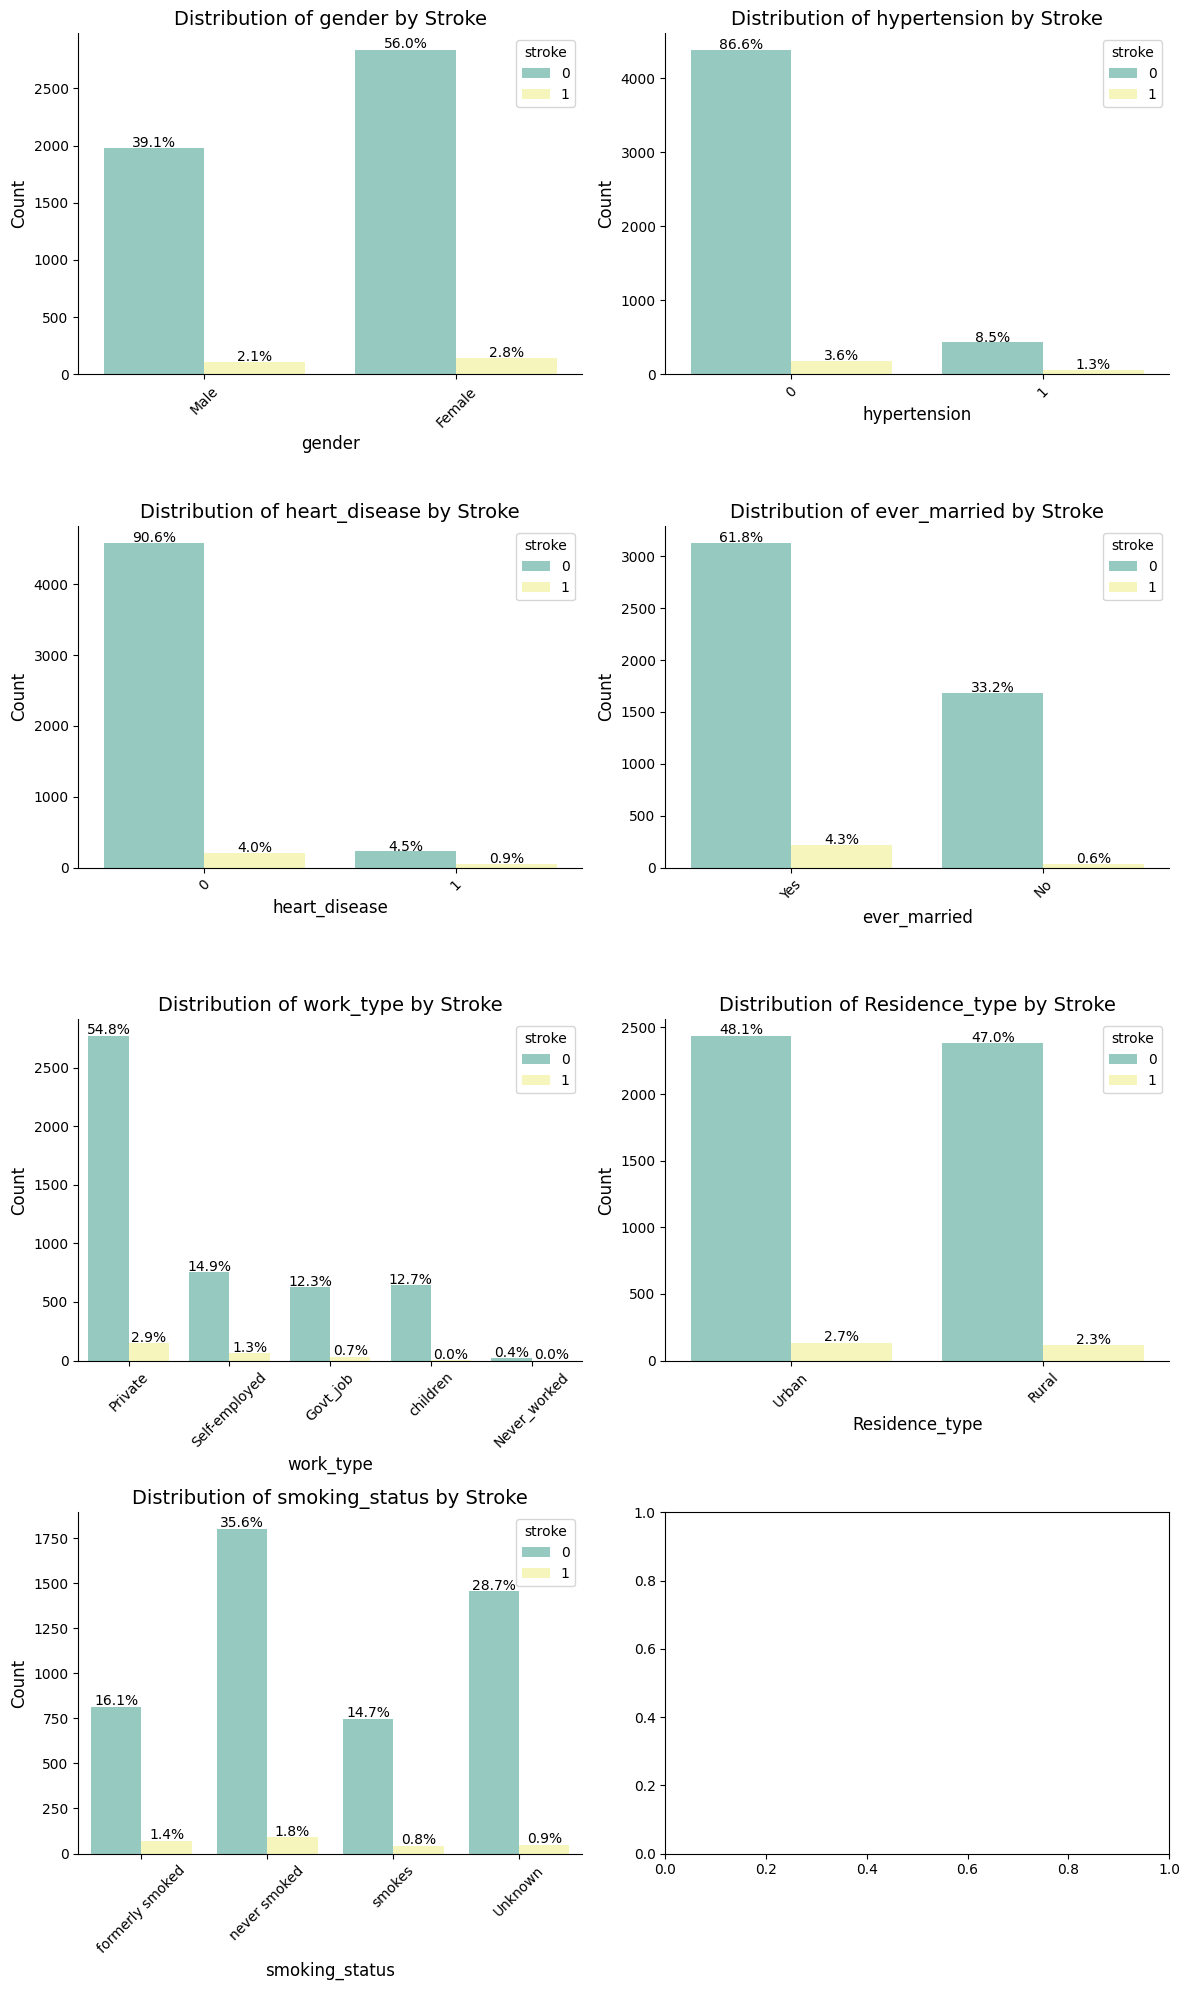

In [16]:
# List of categorical features
columns = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

# Create a figure with subplots in a 4x2 grid layout
fig, axes = plt.subplots(4, 2, figsize=(12, 20))

for i, ax in zip(columns, axes.flatten()):
    # Create a countplot using Seaborn with 'stroke' as hue
    sns.countplot(data=df2, x=i, hue='stroke', ax=ax, palette='Set3')
    
    ax.set_xlabel(i, fontsize=12)  # Label the x-axis with the feature name
    ax.set_ylabel('Count', fontsize=12)  # Label the Y-axis with "Count"
    ax.set_title(f'Distribution of {i} by Stroke', fontsize=14)  # Set a title for each subplot
    ax.tick_params(axis='x', rotation=45)  # Rotate x-axis labels for better readability

    # Adding percentage text on top of each bar
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / df2.shape[0])
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() + 10
        ax.annotate(percentage, (x, y), ha='center', fontsize=10)
        
    # Remove the spines (borders) from the subplots
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

plt.tight_layout()
plt.show()


1. **Gender and Stroke**: The data shows that the majority of both men and women in the dataset have not experienced strokes. Interestingly, there are more women without strokes than men, highlighting potential gender-specific differences in stroke risk factors or outcomes.

2. **Hypertension and Stroke**: It's noteworthy that the number of strokes among people without hypertension is higher than those with hypertension. This suggests that hypertension might not be the sole driver of strokes in this dataset, and other factors could be contributing to stroke risk.

3. **Heart Disease and Stroke**: Surprisingly, individuals without heart disease appear to have a higher likelihood of experiencing a stroke compared to those with heart disease who do have a stroke. This finding raises questions about the interplay of heart disease and stroke risk and warrants further investigation.

4. **Marriage and Stroke**: The data indicates a significant number of individuals who have been married at least once and have experienced strokes. This observation prompts exploration into the relationship between marital status, stroke risk, and long-term health outcomes.

5. **Occupation and Stroke**: The dataset suggests that a higher number of individuals who have experienced strokes work in the private sector or are self-employed compared to other occupational categories. This trend highlights potential occupational factors contributing to health outcomes and the need for workplace health interventions.

6. **Residence Type and Stroke**: Interestingly, among people living in different types of residences, the number of individuals with strokes is almost equal. This finding suggests that residence type may not be a significant factor in predicting strokes.

7. **Smoking Habits and Stroke**: Individuals categorized as never smokers and former smokers appear to have a higher likelihood of experiencing a stroke than other smoking categories. This insight underscores the complex relationship between smoking habits and stroke risk, possibly influenced by other health factors.

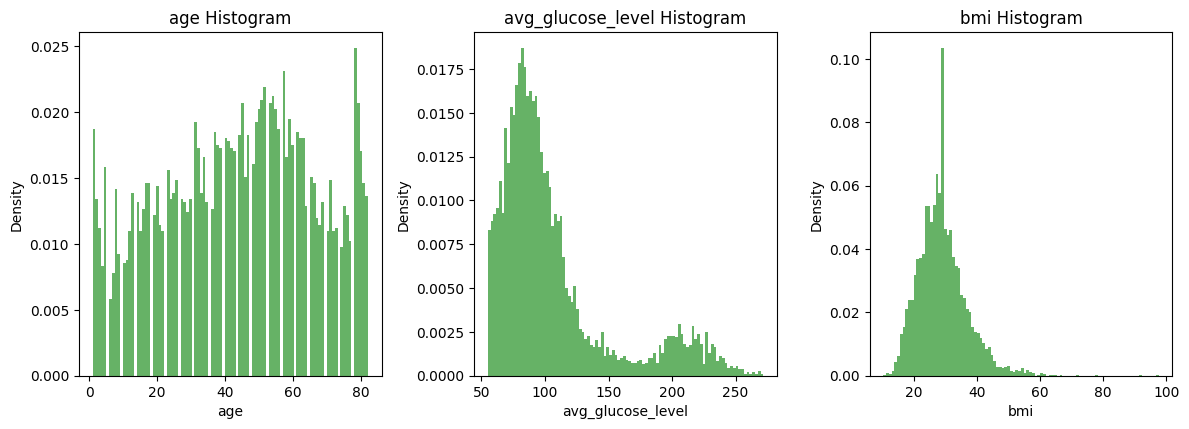

In [17]:
column = ['age', 'avg_glucose_level', 'bmi']

fig, axes = plt.subplots(3, 3, figsize=(12, 12))

axes = axes.flatten()

for i, ax in enumerate(axes):
    if i < len(column):
        n_bins = 100
        ax.hist(df2[column[i]], bins=n_bins, density=True, alpha=0.6, color='g')
        ax.set_xlabel(column[i])
        ax.set_ylabel('Density')
        ax.set_title(column[i] + ' Histogram')

for i in range(len(column), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

1. **Age Distribution**: The dataset encompasses a diverse range of patient ages, with the majority falling within the age range of 50 to 80. This broad age distribution underscores the need to understand stroke risk factors and outcomes across different life stages.

2. **Average Glucose Levels**: Most patients exhibit average glucose levels in the range of 50 to 125. However, there is a notable presence of individuals with higher glucose levels, resulting in a right-skewed distribution. This skewed distribution suggests the importance of exploring the impact of elevated glucose levels on stroke risk and management.

3. **BMI Variability**: The data indicates that the majority of patients have a BMI (Body Mass Index) between 20 and 40, which is considered within the healthy to overweight range. Yet, there are notable outliers with higher BMI values. This observation highlights the significance of investigating the relationship between BMI, obesity, and stroke susceptibility, as well as its implications for healthcare interventions.

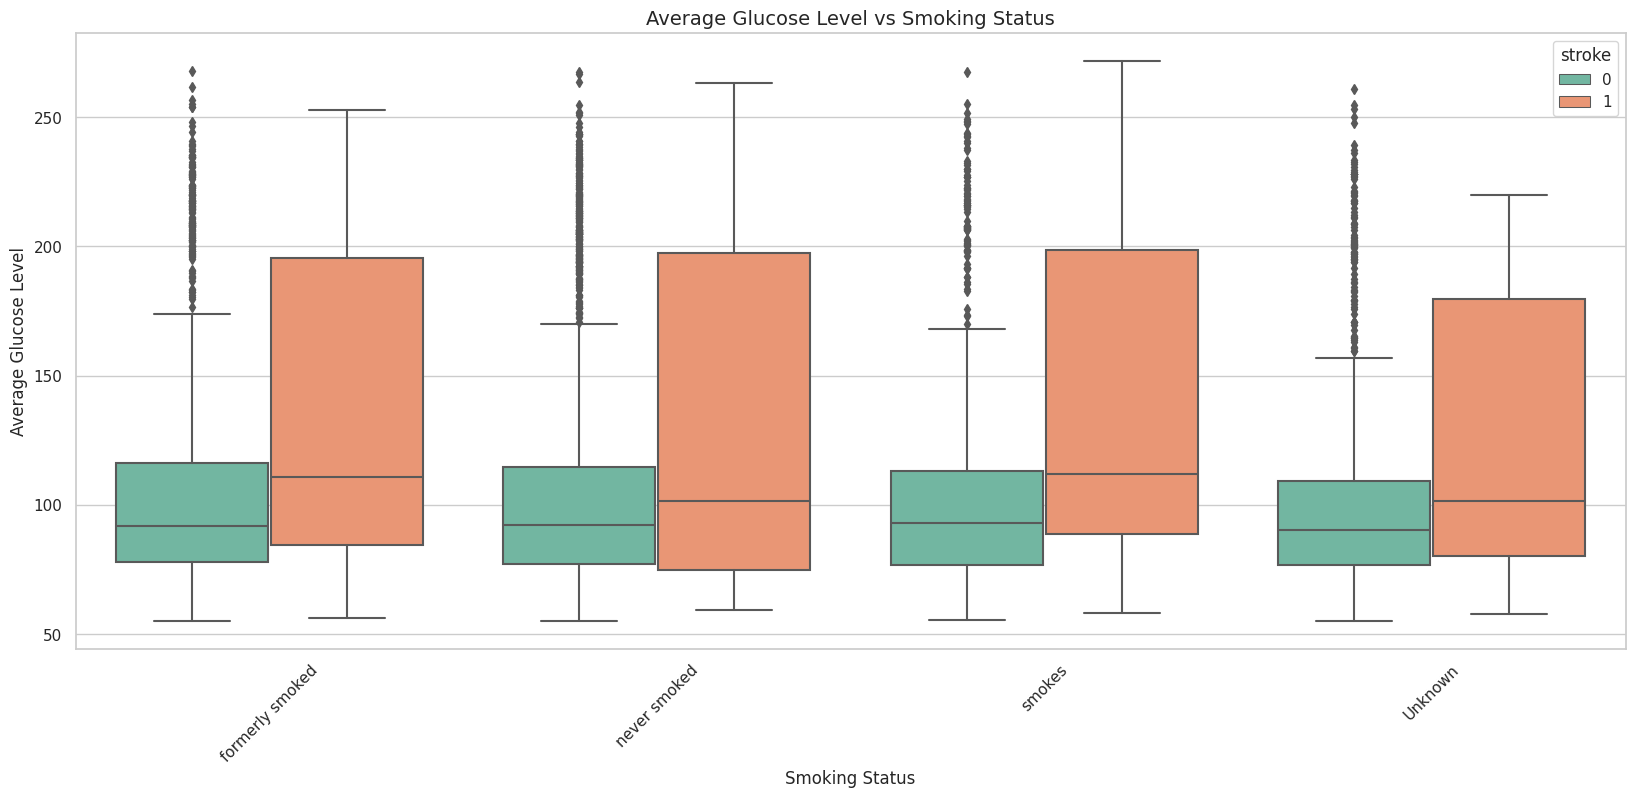

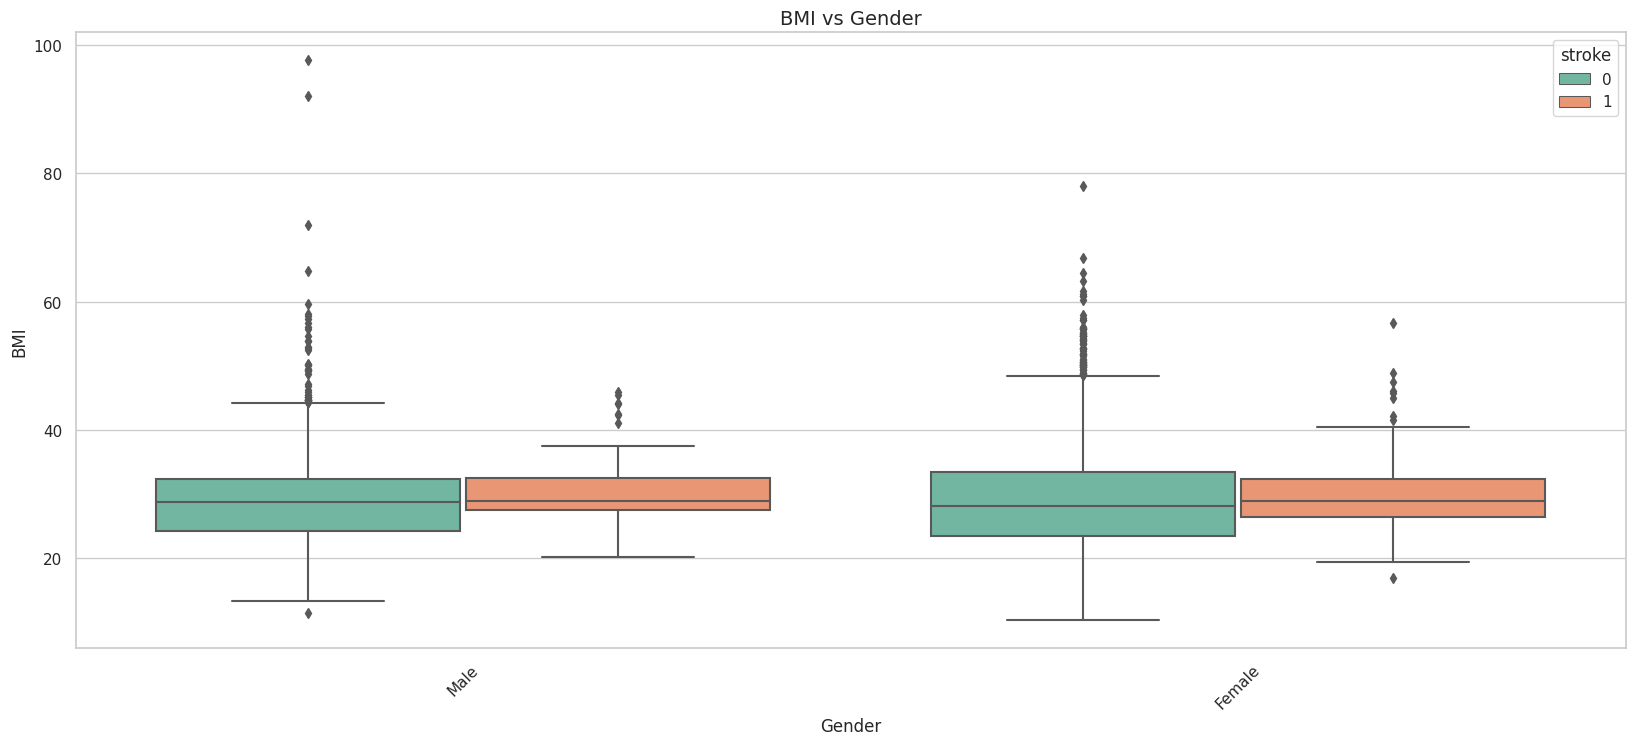

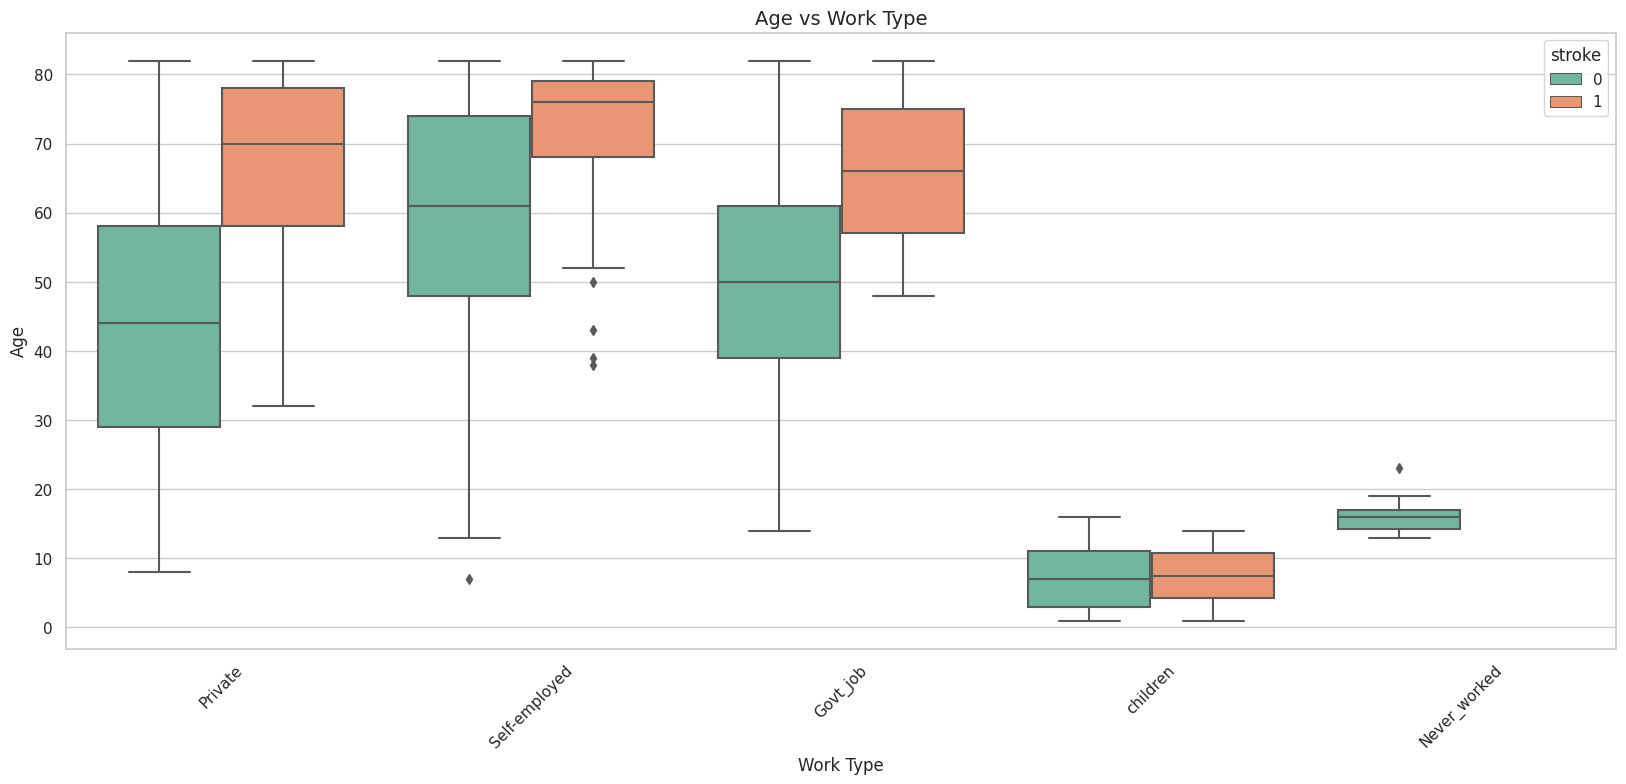

In [18]:
# Set the style of the plots
sns.set(style="whitegrid")

# Boxplot for Average Glucose Level vs Smoking Status with stroke grouping
plt.figure(figsize=(20, 8))
sns.boxplot(x='smoking_status', y='avg_glucose_level', hue='stroke', data=df2, palette='Set2')
plt.title('Average Glucose Level vs Smoking Status', fontsize=14)
plt.xlabel('Smoking Status', fontsize=12)
plt.ylabel('Average Glucose Level', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Boxplot for BMI vs Gender with stroke grouping
plt.figure(figsize=(20, 8))
sns.boxplot(x='gender', y='bmi', hue='stroke', data=df2, palette='Set2')
plt.title('BMI vs Gender', fontsize=14)
plt.xlabel('Gender', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.xticks(rotation=45)
plt.show()

# Boxplot for Age vs Work Type with stroke grouping
plt.figure(figsize=(20, 8))
sns.boxplot(x='work_type', y='age', hue='stroke', data=df2, palette='Set2')
plt.title('Age vs Work Type', fontsize=14)
plt.xlabel('Work Type', fontsize=12)
plt.ylabel('Age', fontsize=12)
plt.xticks(rotation=45)
plt.show()


1. **Average Glucose Levels and Stroke**: Outliers are noticeable in the average glucose levels of non-smokers, former smokers, never smokers, and individuals with unknown smoking conditions. It's important to note that all stroke survivors exhibit high average glucose levels. This emphasizes the potential role of elevated glucose levels in stroke risk.

2. **BMI Distribution Across Genders**: The distribution of BMI among men and women appears to be similar. However, there are outliers among male non-stroke patients with notably high BMIs. Among women and non-stroke individuals, the prevalence of outliers with high BMIs is more pronounced. This highlights the importance of exploring the relationship between BMI, gender, and stroke risk.

3. **Age and Work Sector Impact on Stroke**: Individuals aged 60 and above, especially those working in the private sector, are more likely to experience strokes. Additionally, people aged 65 and older who are self-employed face a higher risk of stroke. Notably, none of those who have never worked have experienced strokes. This insight underscores the intersection of age, occupational factors, and stroke risk.

4. **Pediatric Stroke**: Among children, the age range for those who have experienced strokes is between 5 and 10 years. This finding is particularly significant as it highlights the occurrence of strokes in a younger age group, which may warrant further investigation into pediatric stroke risk factors and management.

<Figure size 2500x1000 with 0 Axes>

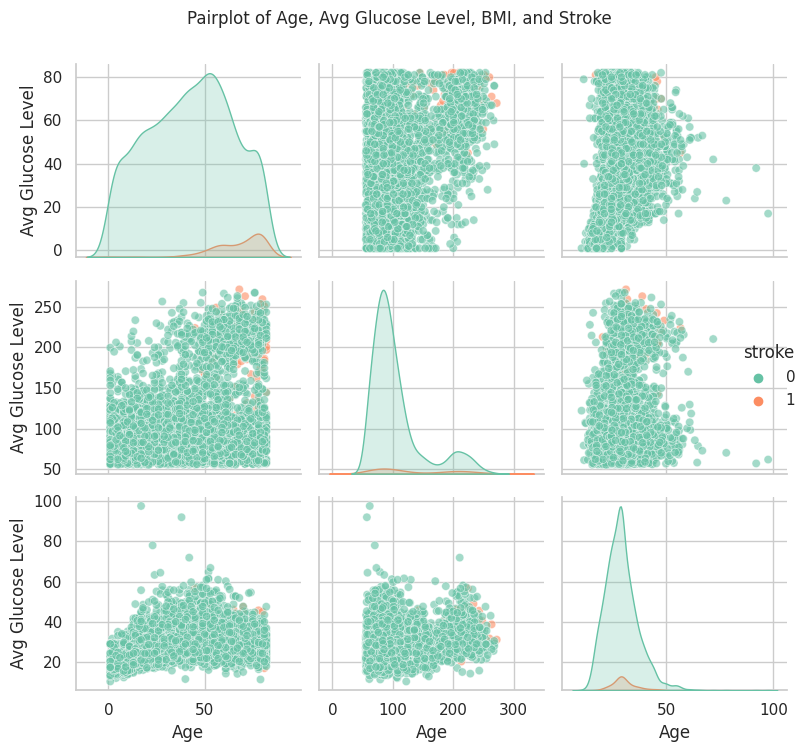

In [19]:
# Create a subset of the DataFrame
subset = df2[['age', 'avg_glucose_level', 'bmi', 'stroke']]

plt.figure(figsize=(25, 10))

# Convert 'stroke' to a categorical variable
subset['stroke'] = subset['stroke'].astype('category')

# Set a custom color palette for the plot
custom_palette = sns.color_palette('Set2')

# Create a pairplot with improved aesthetics
g = sns.pairplot(subset, hue='stroke', palette=custom_palette, plot_kws={'alpha': 0.6})

# Set title and labels
g.fig.suptitle('Pairplot of Age, Avg Glucose Level, BMI, and Stroke', y=1, fontsize=12)
g.set(xlabel='Age', ylabel='Avg Glucose Level')

plt.tight_layout()
plt.show()

1. **Age and Average Glucose Level**: There doesn't appear to be a clear linear relationship between age and average glucose level across the entire dataset. However, it's evident that individuals with stroke (depicted in orange) tend to be older and have higher average glucose levels compared to those without stroke.

2. **Age and BMI**: Similarly, there isn't a straightforward linear relationship between age and BMI. Whether an individual has experienced a stroke or not doesn't seem to have a significant impact on their BMI.

3. **BMI and Average Glucose Level**: There's no evident linear relationship between BMI and average glucose level in the overall dataset. However, it's noteworthy that individuals with stroke have higher average glucose levels compared to those without.

4. **Age Distribution**: The age distribution graph reveals that individuals who have experienced a stroke tend to be older, indicating that age may be a contributing factor to stroke risk.

5. **Average Glucose Level**: On average, individuals with stroke exhibit higher average glucose levels compared to those without stroke. This finding suggests a potential association between elevated glucose levels and stroke.

6. **BMI Distribution**: There isn't a significant difference in the BMI distribution between individuals who have experienced a stroke and those who haven't. BMI might not be a strong indicator of stroke risk in this dataset.

1. **BMI as a Predictor**: It appears that BMI may not be a strong predictor of stroke risk in this dataset. This observation suggests that other factors, such as age and average glucose level, might have a more significant influence on stroke occurrence.

2. **Age and Average Glucose Level**: Age and average glucose level seem to be more effective variables in predicting stroke risk. Older individuals and those with higher average glucose levels are more likely to have a stroke, as indicated by the data.

3. **Occupation and Stroke**: Your observation regarding the higher rate of stroke among self-employed individuals and those working in the private sector is also supported by the data. This suggests that occupation could be a relevant factor in understanding stroke risk. Further analysis and consideration of other factors may help uncover the reasons behind this association.

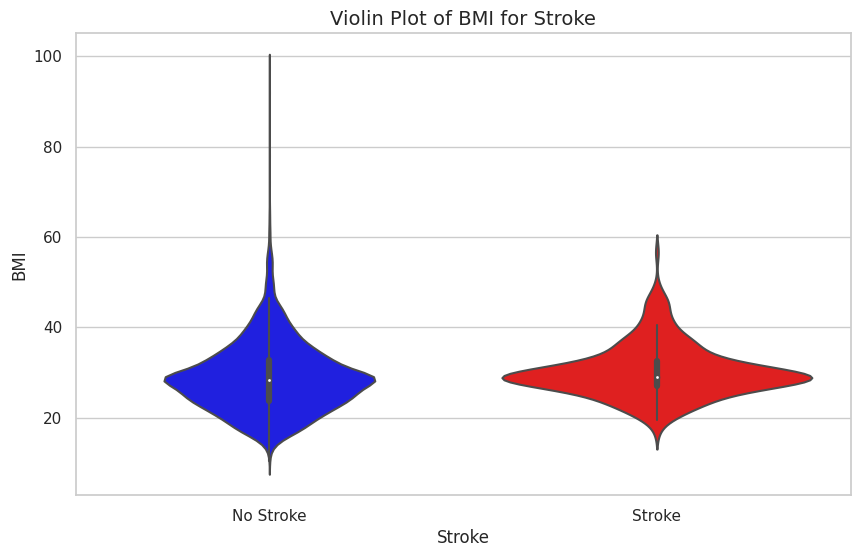

In [20]:
# Create a violin plot of BMI for stroke categories
plt.figure(figsize=(10, 6))
sns.violinplot(data=df2, x='stroke', y='bmi', palette={0: 'blue', 1: 'red'})

plt.xlabel('Stroke', fontsize=12)
plt.ylabel('BMI', fontsize=12)
plt.title('Violin Plot of BMI for Stroke', fontsize=14)
plt.xticks([0, 1], ['No Stroke', 'Stroke'])

plt.show()

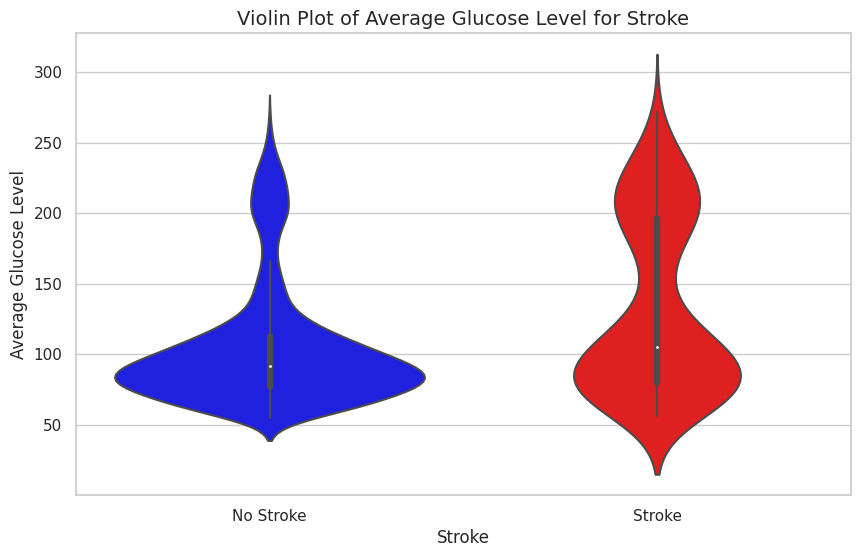

In [21]:
# Create a violin plot of avg_glucose_level for stroke categories
plt.figure(figsize=(10, 6))
sns.violinplot(data=df2, x='stroke', y='avg_glucose_level', palette={0: 'blue', 1: 'red'})

plt.xlabel('Stroke', fontsize=12)
plt.ylabel('Average Glucose Level', fontsize=12)
plt.title('Violin Plot of Average Glucose Level for Stroke', fontsize=14)
plt.xticks([0, 1], ['No Stroke', 'Stroke'])

plt.show()

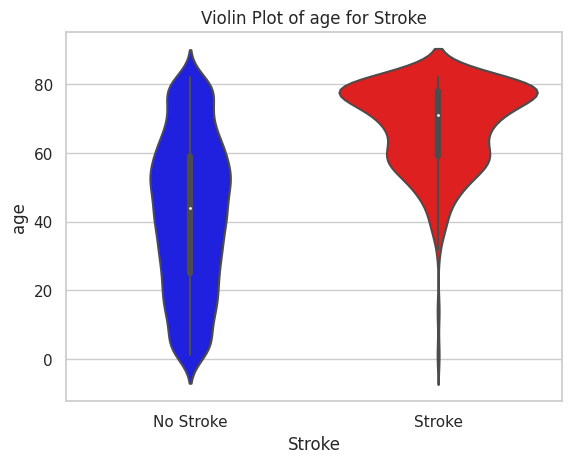

In [22]:
sns.violinplot(data=df2, x='stroke', y='age', palette={0: 'blue', 1: 'red'})
plt.xlabel('Stroke')
plt.ylabel('age')
plt.title('Violin Plot of age for Stroke')
plt.xticks([0, 1], ['No Stroke', 'Stroke'])
plt.show()

In [23]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5066 entries, 0 to 5066
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5066 non-null   object 
 1   age                5066 non-null   int64  
 2   hypertension       5066 non-null   int64  
 3   heart_disease      5066 non-null   int64  
 4   ever_married       5066 non-null   object 
 5   work_type          5066 non-null   object 
 6   Residence_type     5066 non-null   object 
 7   avg_glucose_level  5066 non-null   float64
 8   bmi                5066 non-null   float64
 9   smoking_status     5066 non-null   object 
 10  stroke             5066 non-null   int64  
dtypes: float64(2), int64(4), object(5)
memory usage: 474.9+ KB


In [24]:
def label_encode_object_columns(data):
    # Get the list of columns with object data type
    object_columns = data.select_dtypes(include=['object']).columns

    label_encoder = LabelEncoder()

    # Create a dictionary to store label encoders for each column
    label_encoders = {}

    # Loop through object columns and apply label encoding
    for column in object_columns:
        data[column] = label_encoder.fit_transform(data[column])
        label_encoders[column] = label_encoder

    # Return the modified DataFrame and the label encoders
    return data, label_encoders

In [25]:
label_encode_object_columns(df2)

(      gender  age  hypertension  heart_disease  ever_married  work_type  Residence_type  avg_glucose_level        bmi  smoking_status  stroke
 0          1   67             0              1             1          2               1             228.69  36.600000               1       1
 1          0   61             0              0             1          3               0             202.21  28.987074               2       1
 2          1   80             0              1             1          2               0             105.92  32.500000               2       1
 3          0   49             0              0             1          2               1             171.23  34.400000               3       1
 4          0   79             1              0             1          3               0             174.12  24.000000               2       1
 ...      ...  ...           ...            ...           ...        ...             ...                ...        ...             ...     ...

In [26]:
# Let's calculate the quartiles of each variable
q1 = df2.quantile(0.25)
q3 = df2.quantile(0.75)

# Let's use quartiles to detect outliers for numeric columns (excluding categorical columns)
numeric_columns = df2.select_dtypes(include=['number']).columns

# Initialize an empty list to store outlier counts
outliers_count = []

# Loop through numeric columns and calculate the number of outliers
for column in numeric_columns:
    if column not in ["age", "stroke", "hypertension", "heart_disease"]:
        lower_bound = q1[column] - 1.5 * (q3[column] - q1[column])
        upper_bound = q3[column] + 1.5 * (q3[column] - q1[column])
        outliers = ((df2[column] < lower_bound) | (df2[column] > upper_bound)).sum()
        outliers_count.append({"Variable": column, "Outlier Count": outliers})

# Convert the list of dictionaries into a DataFrame
outliers_count_df = pd.DataFrame(outliers_count)

# Print the outlier counts to the screen
print("Outlier Numbers (Excluding Categorical Variables):")
print(outliers_count_df)

Outlier Numbers (Excluding Categorical Variables):
            Variable  Outlier Count
0             gender              0
1       ever_married              0
2          work_type            657
3     Residence_type              0
4  avg_glucose_level            627
5                bmi            128
6     smoking_status              0


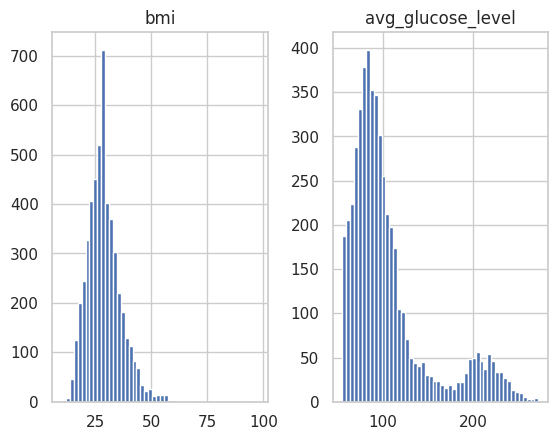

In [27]:
df2[['bmi','avg_glucose_level']].hist(bins=50)
plt.show()

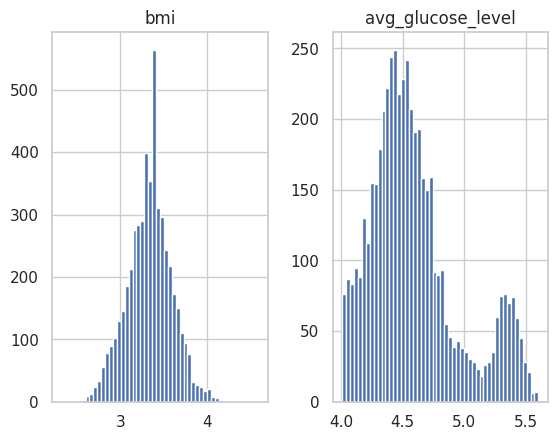

In [28]:
# Apply logarithmic transformation to 'avg_glucose_level' and 'bmi' columns
df2['avg_glucose_level'] = np.log(df2['avg_glucose_level'])
df2['bmi'] = np.log(df2['bmi'])
df2[['bmi','avg_glucose_level']].hist(bins=50)
plt.show()

In [29]:
#Let's check the outlier counts again

q1 = df2.quantile(0.25)
q3 = df2.quantile(0.75)

# Let's use quartiles to detect outliers for numeric columns (excluding categorical columns)
numeric_columns = df2.select_dtypes(include=['number']).columns

# Initialize an empty list to store outlier counts
outliers_count = []

# Loop through numeric columns and calculate the number of outliers
for column in numeric_columns:
    if column not in ["age", "stroke", "hypertension", "heart_disease"]:
        lower_bound = q1[column] - 1.5 * (q3[column] - q1[column])
        upper_bound = q3[column] + 1.5 * (q3[column] - q1[column])
        outliers = ((df2[column] < lower_bound) | (df2[column] > upper_bound)).sum()
        outliers_count.append({"Variable": column, "Outlier Count": outliers})

# Convert the list of dictionaries into a DataFrame
outliers_count_df = pd.DataFrame(outliers_count)

# Print the outlier counts to the screen
print("Outlier Numbers (Excluding Categorical Variables):")
print(outliers_count_df)

Outlier Numbers (Excluding Categorical Variables):
            Variable  Outlier Count
0             gender              0
1       ever_married              0
2          work_type            657
3     Residence_type              0
4  avg_glucose_level            381
5                bmi             89
6     smoking_status              0


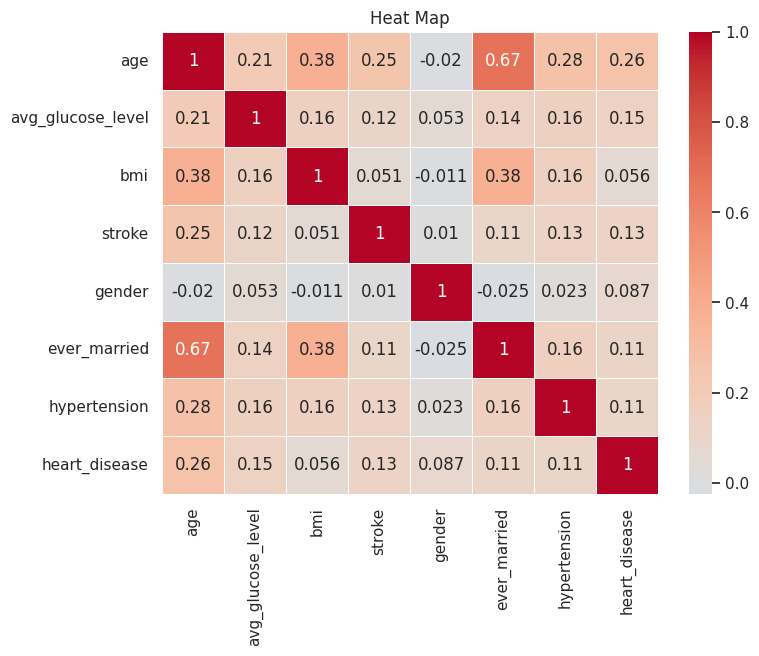

In [30]:
# Select the relevant columns for the heatmap
heat_map_data = df2[['age','avg_glucose_level','bmi','stroke',
                     'gender','ever_married','hypertension','heart_disease']]

# Calculate the correlation matrix
correlation_matrix = heat_map_data.corr()

# Create the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", center=0, linewidths=0.5)
plt.title("Heat Map")
plt.show()


In [31]:
def refine(data):
    # Store the column names before standardization
    column_names = data.columns

    # Standardize the data
    scaler = StandardScaler()
    data = scaler.fit_transform(data)

    # Convert back to a DataFrame using the original column names
    dfx = pd.DataFrame(data, columns=column_names)

    return dfx

In [32]:
refine(df2)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,1.194742,1.046509,-0.330181,4.165942,0.714763,-0.140695,0.984331,2.315651,1.035475,-0.363756,4.398338
1,-0.837001,0.778340,-0.330181,-0.240042,0.714763,0.783770,-1.015918,1.976128,0.128959,0.572144,4.398338
2,1.194742,1.627543,-0.330181,4.165942,0.714763,-0.140695,-1.015918,0.192099,0.573630,0.572144,4.398338
3,-0.837001,0.242002,-0.330181,-0.240042,0.714763,-0.140695,0.984331,1.517309,0.794494,1.508044,4.398338
4,-0.837001,1.582848,3.028645,-0.240042,0.714763,0.783770,-1.015918,1.563487,-0.604951,0.572144,4.398338
...,...,...,...,...,...,...,...,...,...,...,...
5061,-0.837001,1.627543,3.028645,-0.240042,0.714763,-0.140695,0.984331,-0.455845,0.128959,0.572144,-0.227359
5062,-0.837001,1.672237,-0.330181,-0.240042,0.714763,0.783770,0.984331,0.653481,1.380790,0.572144,-0.227359
5063,-0.837001,-0.383727,-0.330181,-0.240042,0.714763,0.783770,-1.015918,-0.480996,0.339458,0.572144,-0.227359
5064,1.194742,0.331391,-0.330181,-0.240042,0.714763,-0.140695,-1.015918,1.436541,-0.354069,-0.363756,-0.227359


In [33]:
def random_forest_classifier(data, target_column, test_size=0.3, n_estimators=100, random_state=42):
    # Extract features (X) and target variable (y)
    X = data.drop(columns='stroke')
    y = data['stroke']
    
    x_cols = X.columns
    
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Create the RandomForestClassifier model
    model = RandomForestClassifier(n_estimators=n_estimators, random_state=random_state)

    # Train the model
    model.fit(X_train, y_train)
    feature_importances = model.feature_importances_
    # Make predictions on the test data
    predictions = model.predict(X_test)

    # Evaluate the model
    accuracy = accuracy_score(y_test, predictions)
    confusion = confusion_matrix(y_test, predictions)
    classification_rep = classification_report(y_test, predictions, output_dict=True)

    # Create a DataFrame for the metrics
    metrics_df = pd.DataFrame({
        'Accuracy': [accuracy],
        'Confusion Matrix': [confusion],
        'Classification Report': [classification_rep]
    })
    
    importances_df = pd.DataFrame({
        'Feature': x_cols,
        'Importance': feature_importances
    })

    importances_df = importances_df.sort_values(by='Importance', ascending=False)

    plt.figure(figsize=(10, 8))
    sns.barplot(data=importances_df, x='Importance', y='Feature', color='b')
    plt.title('Feature Importance')
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.show()

    
    return metrics_df, accuracy, confusion, classification_rep,y_test, importances_df 

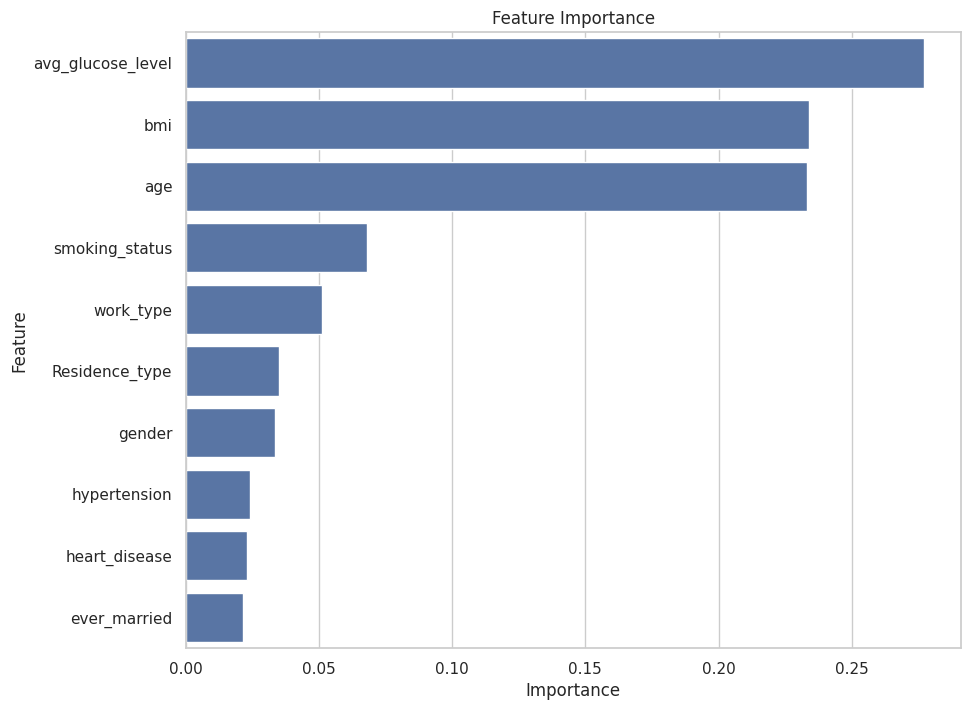

In [34]:
# metrics_df, accuracy, confusion, classification_re = random_forest_classifier(data, 'target')
metrics_df, accuracy, confusion, classification_rep,y_test,important_features  = random_forest_classifier(df2, 'stroke')


In [35]:
#print("Mean Absolute Error:", mse)
#print("R-squared Score:", r2)
print("Accuracy:", accuracy)

Accuracy: 0.9414473684210526


In [36]:
 pprint.pprint(classification_rep)

{'0': {'f1-score': 0.9698407319552694,
       'precision': 0.9420671494404214,
       'recall': 0.9993016759776536,
       'support': 1432},
 '1': {'f1-score': 0.0, 'precision': 0.0, 'recall': 0.0, 'support': 88},
 'accuracy': 0.9414473684210526,
 'macro avg': {'f1-score': 0.4849203659776347,
               'precision': 0.4710335747202107,
               'recall': 0.4996508379888268,
               'support': 1520},
 'weighted avg': {'f1-score': 0.9136920579999643,
                  'precision': 0.8875264197359759,
                  'recall': 0.9414473684210526,
                  'support': 1520}}


In [37]:
# Define a parameter grid to search for the best hyperparameters
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

In [38]:
# Create the RandomForestClassifier model
rf_model = RandomForestClassifier(random_state=42)

In [39]:
# Create GridSearchCV object
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

In [40]:
# Extract features (X) and target variable (y)
X = df2.drop(columns='stroke')
y = df2['stroke']

x_cols = X.columns

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.3, random_state=42)


In [41]:
# Fit the grid search to the data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.3s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   0.6s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=5, n_estimators=200; total time=   1.2s
[CV] END max_depth=None, max_features=sqrt, min_samples_leaf=1, min_samples_split=10

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 10, 20, 30],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [50, 100, 200]},
             verbose=2)

In [42]:
# Get the best parameters from the grid search
best_params = grid_search.best_params_

In [43]:
# Create and train the final model with the best parameters
final_model = RandomForestClassifier(random_state=42, **best_params)
final_model.fit(X_train, y_train)

RandomForestClassifier(min_samples_leaf=4, n_estimators=50, random_state=42)

*RandomForestClassifier(min_samples_leaf=4, n_estimators=50, random_state=42)*

In [44]:
# Make predictions on the test data
predictions = final_model.predict(X_test)

In [45]:
# Evaluate the model
accuracy = accuracy_score(y_test, predictions)
confusion = confusion_matrix(y_test, predictions)
classification_rep = classification_report(y_test, predictions, output_dict=True)

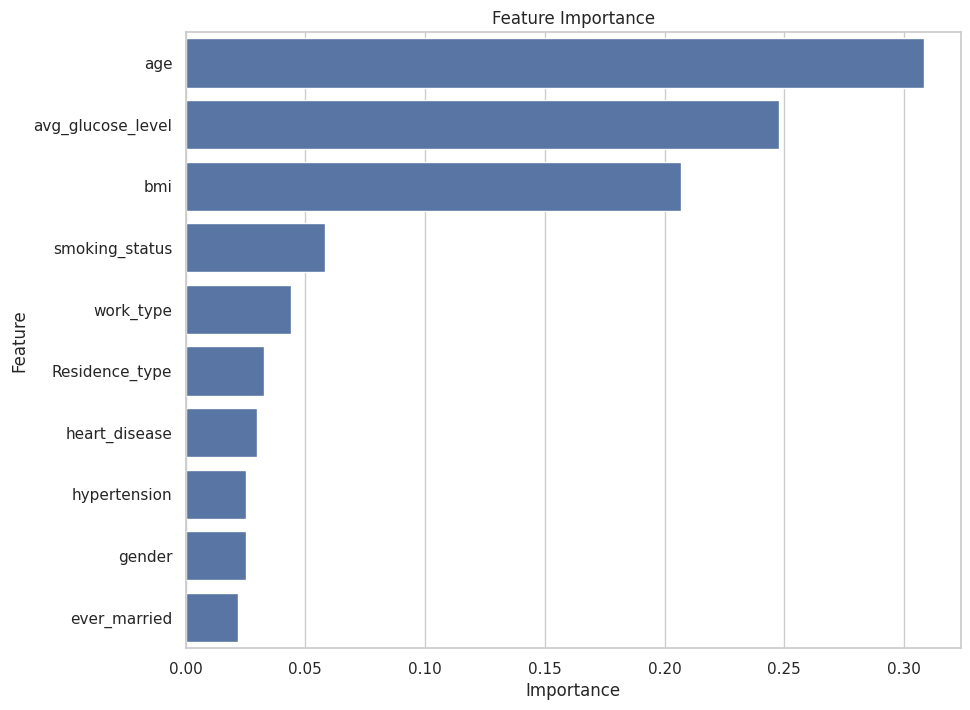

In [46]:
# Create a DataFrame for the metrics
metrics_df = pd.DataFrame({
    'Accuracy': [accuracy],
    'Confusion Matrix': [confusion],
    'Classification Report': [classification_rep]
})

importances_df = pd.DataFrame({
    'Feature': x_cols,
    'Importance': final_model.feature_importances_
})

importances_df = importances_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(data=importances_df, x='Importance', y='Feature', color='b')
plt.title('Feature Importance')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()


In [47]:
metrics_df['Accuracy']

0    0.942105
Name: Accuracy, dtype: float64

In [48]:
classification_rep

{'0': {'precision': 0.9421052631578948,
  'recall': 1.0,
  'f1-score': 0.970189701897019,
  'support': 1432},
 '1': {'precision': 0.0, 'recall': 0.0, 'f1-score': 0.0, 'support': 88},
 'accuracy': 0.9421052631578948,
 'macro avg': {'precision': 0.4710526315789474,
  'recall': 0.5,
  'f1-score': 0.4850948509485095,
  'support': 1520},
 'weighted avg': {'precision': 0.8875623268698061,
  'recall': 0.9421052631578948,
  'f1-score': 0.9140208244187705,
  'support': 1520}}